In [1]:
import params as p
import datalib as dl
import matplotlib.pyplot as plt
import talib
import seaborn as sns
import numpy as np
import pandas as pd

In [ ]:
# Inspired by:
# Machine Learning for Finance in Python
# https://campus.datacamp.com/courses/machine-learning-for-finance-in-python

# Preparing data and a linear model

In [ ]:
# Explore the data with some EDA


**************** Loaded Config for ETHUSDNN ****************
*** Loading Data ***
Using loaded prices for 2019-03-06
            close  high     low    open   volume  volumeto       date
date                                                                 
2015-08-07   3.00  3.00  0.6747  0.6747   123.93    371.79 2015-08-07
2015-08-08   1.20  3.00  0.1500  3.0000  1942.89   1164.16 2015-08-08
2015-08-11   0.99  1.20  0.6504  1.2000  9234.57   7176.75 2015-08-11
2015-08-12   1.29  1.29  0.9050  0.9900  1736.11   1899.47 2015-08-12
2015-08-13   1.88  1.88  1.2600  1.2900  2815.45   4336.94 2015-08-13


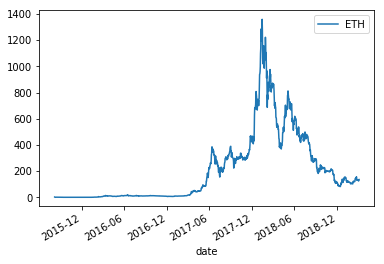

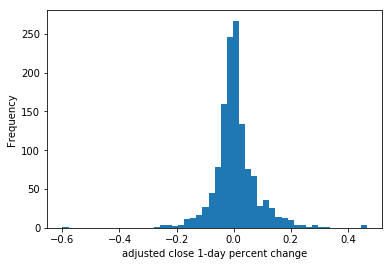

In [2]:
conf = 'ETHUSDNN'
p.load_config(conf)
ds = dl.load_price_data()
ds = ds[ds.volume > 0]
ds.index = ds.date

print(ds.head(5))  # examine the DataFrames

# Plot the close column for ETH
ds['close'].plot(label='ETH', legend=True)
plt.show()  # show the plot
plt.clf()  # clear the plot space

# Histogram of the daily price change percent of close for LNG
ds['close'].pct_change().plot.hist(bins=50)
plt.xlabel('adjusted close 1-day percent change')
plt.show()

                     5d_close_pct  5d_close_future_pct
5d_close_pct             1.000000             0.086637
5d_close_future_pct      0.086637             1.000000


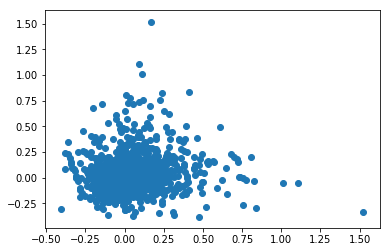

In [4]:
# Correlations

# Create 5-day % changes of close for the current day, and 5 days in the future
ds['5d_future_close'] = ds['close'].shift(-5)
ds['5d_close_future_pct'] = ds['5d_future_close'].pct_change(5)
ds['5d_close_pct'] = ds['close'].pct_change(5)

# Calculate the correlation matrix between the 5d close pecentage changes (current and future)
corr = ds[['5d_close_pct', '5d_close_future_pct']].corr()
print(corr)

# Scatter the current 5-day percent change vs the future 5-day percent change
plt.scatter(ds['5d_close_pct'], ds['5d_close_future_pct'])
plt.show()

In [5]:
# Create moving average and RSI features

feature_names = ['5d_close_pct'] # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14, 30, 50, 200]:
    # Create the moving average indicator and divide by close
    ds['ma' + str(n)] = talib.SMA(ds['close'].values,
                              timeperiod=n) / ds['close']
    # Create the RSI indicator
    ds['rsi' + str(n)] = talib.RSI(ds['close'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

print(feature_names)

['5d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']


In [6]:
# Create features and targets
# Drop all na values
ds = ds.dropna()

# Create features and targets
# use feature_names for features; 5d_close_future_pct for targets
features = ds[feature_names]
targets = ds['5d_close_future_pct']

# Create DataFrame from target column and feature columns
feat_targ_df = ds[['5d_close_future_pct'] + feature_names]

# Calculate correlation matrix
corr = feat_targ_df.corr()
print(corr)

                     5d_close_future_pct  5d_close_pct      ma14     rsi14  \
5d_close_future_pct             1.000000      0.103848 -0.131680  0.202077   
5d_close_pct                    0.103848      1.000000 -0.842857  0.707197   
ma14                           -0.131680     -0.842857  1.000000 -0.861422   
rsi14                           0.202077      0.707197 -0.861422  1.000000   
ma30                           -0.176074     -0.669502  0.879514 -0.934135   
rsi30                           0.216742      0.597353 -0.726840  0.936092   
ma50                           -0.140398     -0.533764  0.723061 -0.899157   
rsi50                           0.219033      0.531305 -0.634510  0.849121   
ma200                          -0.137336     -0.294915  0.402162 -0.608722   
rsi200                          0.171477      0.407059 -0.475505  0.671467   

                         ma30     rsi30      ma50     rsi50     ma200  \
5d_close_future_pct -0.176074  0.216742 -0.140398  0.219033 -0.13733

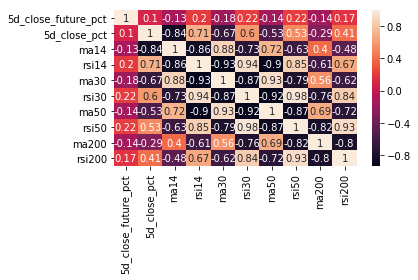

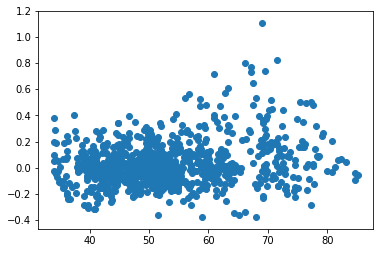

In [7]:
# Check the correlations

# Plot heatmap of correlation matrix
sns.heatmap(corr, annot=True)
plt.yticks(rotation=0); plt.xticks(rotation=90)  # fix ticklabel directions
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot
plt.clf()  # clear the plot area

# Create a scatter plot of the most highly correlated variable with the target
plt.scatter(ds['rsi50'], ds['5d_close_future_pct'])
plt.show()

In [8]:
# Create train and test features

# Import the statsmodels.api library with the alias sm
import statsmodels.api as sm

# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * features.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

(1095, 10) (930, 10) (165, 10)


                             OLS Regression Results                            
Dep. Variable:     5d_close_future_pct   R-squared:                       0.148
Model:                             OLS   Adj. R-squared:                  0.139
Method:                  Least Squares   F-statistic:                     17.73
Date:                 Wed, 06 Mar 2019   Prob (F-statistic):           2.68e-27
Time:                         22:03:13   Log-Likelihood:                 444.45
No. Observations:                  930   AIC:                            -868.9
Df Residuals:                      920   BIC:                            -820.5
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.9538      0.183    

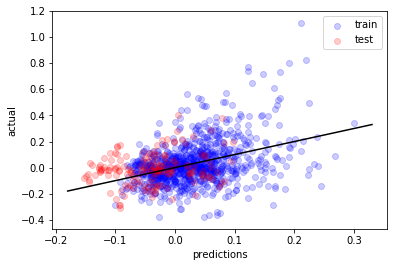

In [9]:
# Fit a linear model

# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

# Evaluate our results

# Scatter the predictions vs the targets with 80% transparency
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

# Machine learning tree methods

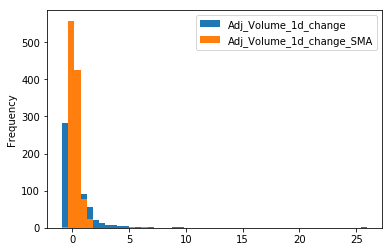

In [10]:
# Feature engineering from volume

# Create 2 new volume features, 1-day % change and 5-day SMA of the % change
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)
ds['Adj_Volume_1d_change'] = ds['volume'].pct_change()
ds['Adj_Volume_1d_change_SMA'] = talib.SMA(ds['Adj_Volume_1d_change'].values, timeperiod=5)

# Plot histogram of volume % change data
ds[new_features].plot(kind='hist', sharex=False, bins=50)
plt.show()

In [11]:
# Create day-of-week features

# Use pandas' get_dummies function to get dummies for day of the week
days_of_week = pd.get_dummies(ds.index.dayofweek,
                              prefix='weekday',
                              drop_first=True)

# Set the index as the original dataframe index for merging
days_of_week.index = ds.index

# Join the dataframe with the days of week dataframe
ds = pd.concat([ds, days_of_week], axis=1)

# Add days of week to feature names
feature_names.extend(['weekday_' + str(i) for i in range(1, 7)])
ds.dropna(inplace=True)  # drop missing values in-place
print(ds.head())

            close   high   low   open     volume    volumeto       date  \
date                                                                      
2016-03-03   9.35   9.94  8.30   8.70   85546.90   800977.70 2016-03-03   
2016-03-04   9.96   9.96  8.27   9.35   91589.10   866953.71 2016-03-04   
2016-03-05  11.00  12.00  9.75   9.96  152475.01  1609872.81 2016-03-05   
2016-03-06  10.98  11.90  9.75  11.00   67041.65   728203.86 2016-03-06   
2016-03-07   9.50  11.47  9.06  10.98   66012.40   660786.54 2016-03-07   

            5d_future_close  5d_close_future_pct  5d_close_pct    ...      \
date                                                              ...       
2016-03-03             9.88             0.056684      0.481775    ...       
2016-03-04            11.55             0.159639      0.532308    ...       
2016-03-05            11.11             0.010000      0.732283    ...       
2016-03-06            11.25             0.024590      0.446640    ...       
2016-03-07  

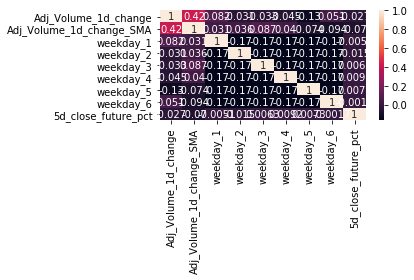

In [12]:
# Examine correlations of the new features

# Add the weekday labels to the new_features list
new_features.extend(['weekday_'+str(i) for i in range(1, 7)])

# Plot the correlations between the new features and the targets
sns.heatmap(ds[new_features + ['5d_close_future_pct']].corr(), annot=True)
plt.yticks(rotation=0)  # ensure y-axis ticklabels are horizontal
plt.xticks(rotation=90)  # ensure x-axis ticklabels are vertical
plt.tight_layout()
plt.show()

## Fit a decision tree

In [13]:
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regression model with default arguments
decision_tree = DecisionTreeRegressor()

# Fit the model to the training features and targets
decision_tree.fit(train_features, train_targets)

# Check the score on train and test
print(decision_tree.score(train_features, train_targets))
print(decision_tree.score(test_features, test_targets))

0.9999999514970691
-2.698339599245523


In [14]:
# Try different max depths

for d in [3, 5, 10]:
    # Create the tree and fit it
    decision_tree = DecisionTreeRegressor(max_depth=d)
    decision_tree.fit(train_features, train_targets)

    # Print out the scores on train and test
    print('max_depth=', str(d))
    print(decision_tree.score(train_features, train_targets))
    print(decision_tree.score(test_features, test_targets), '\n')

max_depth= 3
0.18675862577697422
-0.27642642566292164 

max_depth= 5
0.42422142021557474
-0.4645996156175732 

max_depth= 10
0.8789193162579519
-1.290746428919963 



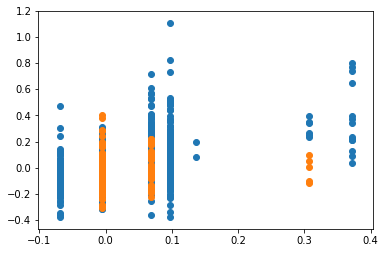

In [15]:
# Check our results

# Use the best max_depth of 3 from last exercise to fit a decision tree
decision_tree = DecisionTreeRegressor(max_depth=3)
decision_tree.fit(train_features, train_targets)

# Predict values for train and test
train_predictions = decision_tree.predict(train_features)
test_predictions = decision_tree.predict(test_features)

# Scatter the predictions vs actual values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
plt.show()

## Fit a random forest

In [16]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.9253479469927108
-0.6800463642067769


In [17]:
# Tune random forest hyperparameters
from sklearn.model_selection import ParameterGrid

# Create a dictionary of hyperparameters to search
grid = {'n_estimators': [50, 100, 200], 'max_depth': [3, 4, 5], 'max_features': [2,4,8], 'random_state': [42]}
test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(train_features, train_targets)
    test_scores.append(rfr.score(test_features, test_targets))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

-0.05059502896275636 {'random_state': 42, 'n_estimators': 100, 'max_features': 2, 'max_depth': 3}


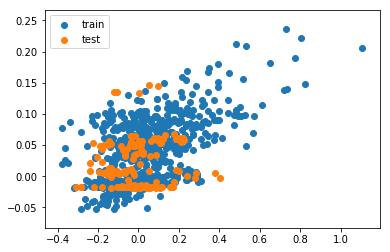

In [18]:
# Evaluate performance

# Use the best hyperparameters from before to fit a random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=4, random_state=42)
rfr.fit(train_features, train_targets)

# Make predictions with our model
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_targets, train_predictions, label='train')
plt.scatter(test_targets, test_predictions, label='test')
plt.legend()
plt.show()

## Random forest feature importances

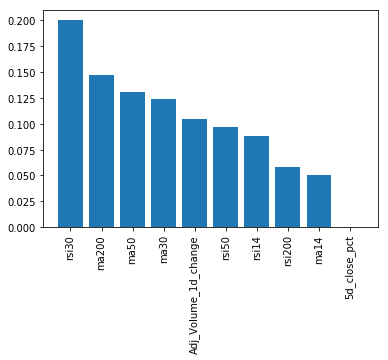

In [20]:
# Get feature importances from our random forest model
importances = rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

## A gradient boosting model

In [21]:
from sklearn.ensemble import GradientBoostingRegressor

# Create GB model -- hyperparameters have already been searched for you
gbr = GradientBoostingRegressor(max_features=4,
                                learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6,
                                random_state=42)
gbr.fit(train_features, train_targets)

print(gbr.score(train_features, train_targets))
print(gbr.score(test_features, test_targets))

0.3202137344415875
-0.06436756923412768


## Gradient boosting feature importances

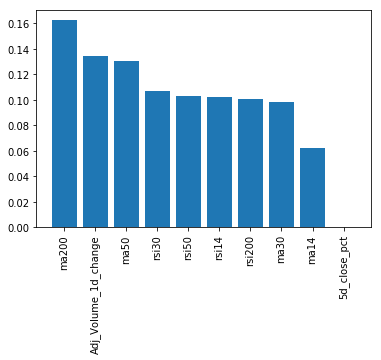

In [27]:
# Extract feature importances from the fitted gradient boosting model
feature_importances = gbr.feature_importances_

# Get the indices of the largest to smallest feature importances
sorted_index = np.argsort(feature_importances)[::-1]
x = range(len(feature_importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]

plt.bar(x, feature_importances[sorted_index], tick_label=labels)

# Set the tick lables to be the feature names, according to the sorted feature_idx
plt.xticks(rotation=90)
plt.show()

# Neural networks and KNN

## Standardizing data

In [30]:
test_features.head()

,const,5d_close_pct,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200
date,,,,,,,,,,
2018-09-18,1.0,-0.016810,0.992930,38.570724,1.188869,36.648334,1.386197,38.747777,2.354345,46.882833
2018-09-19,1.0,0.006282,0.979153,39.223683,1.170095,36.932877,1.354416,38.889094,2.320945,46.904988
2018-09-20,1.0,0.009289,0.916294,44.722111,1.088519,39.380352,1.252244,40.114171,2.161551,47.097689
2018-09-21,1.0,0.125620,0.838327,52.519208,0.981723,43.222226,1.119694,42.110110,1.943354,47.420943
2018-09-22,1.0,0.228443,0.875624,50.277880,1.005088,42.406310,1.137192,41.693976,1.987314,47.335633


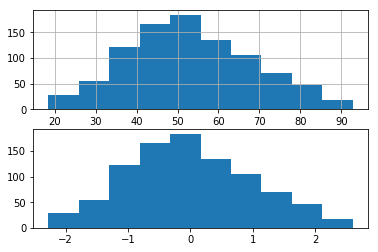

In [32]:
from sklearn.preprocessing import scale

# Standardize the train and test features
scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)

# Plot histograms of the 14-day SMA RSI before and after scaling
f, ax = plt.subplots(nrows=2, ncols=1)
train_features.iloc[:, 3].hist(ax=ax[0])
ax[1].hist(scaled_train_features[:, 3])
plt.show()

## Optimize n_neighbors

In [40]:
from sklearn.neighbors import KNeighborsRegressor

for n in range(2, 13):
    # Create and fit the KNN model
    knn = KNeighborsRegressor(n_neighbors=n)
    
    # Fit the model to the training data
    knn.fit(scaled_train_features, train_targets)
    
    # Print number of neighbors and the score to find the best value of n
    print("n_neighbors =", n)
    print('train, test scores')
    print(knn.score(scaled_train_features, train_targets))
    print(knn.score(scaled_test_features, test_targets))
    print()  # prints a blank line

n_neighbors = 2
train, test scores
0.8401459859629712
-3.9431795947350237

n_neighbors = 3
train, test scores
0.7253655375535946
-3.1612223663854637

n_neighbors = 4
train, test scores
0.6611421954988022
-2.426552663506089

n_neighbors = 5
train, test scores
0.5914107711445786
-1.9140873401013228

n_neighbors = 6
train, test scores
0.5518293518213164
-1.6258974273302016

n_neighbors = 7
train, test scores
0.5143616995854625
-1.3449782907199048

n_neighbors = 8
train, test scores
0.4894188743015876
-1.1232535167453928

n_neighbors = 9
train, test scores
0.45268811297467615
-1.0073065142516562

n_neighbors = 10
train, test scores
0.42666167575642666
-0.8490712315817093

n_neighbors = 11
train, test scores
0.40191951720895636
-0.7231062767230896

n_neighbors = 12
train, test scores
0.3792598123802811
-0.7106893289171594



## Evaluate KNN performance

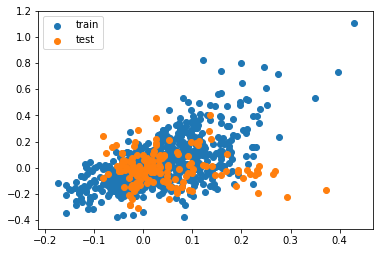

In [41]:
# Create the model with the best-performing n_neighbors of 5
knn = KNeighborsRegressor(n_neighbors=12)

# Fit the model
knn.fit(scaled_train_features, train_targets)

# Get predictions for train and test sets
train_predictions = knn.predict(scaled_train_features)
test_predictions = knn.predict(scaled_test_features)

# Plot the actual vs predicted values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
plt.legend()
plt.show()

## Build and fit a simple neural net

In [42]:
from keras.models import Sequential
from keras.layers import Dense

# Create the model
model_1 = Sequential()
model_1.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_1.add(Dense(20, activation='relu'))
model_1.add(Dense(1, activation='linear'))

# Fit the model
model_1.compile(optimizer='adam', loss='mse')
history = model_1.fit(scaled_train_features, train_targets, epochs=25)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Epoch 1/25
930/930 [==============================] - 0s 213us/step - loss: 0.0423
Epoch 2/25
930/930 [==============================] - 0s 29us/step - loss: 0.0257
Epoch 3/25
930/930 [==============================] - 0s 29us/step - loss: 0.0237
Epoch 4/25
930/930 [==============================] - 0s 29us/step - loss: 0.0228
Epoch 5/25
930/930 [==============================] - 0s 27us/step - loss: 0.0219
Epoch 6/25
930/930 [==============================] - 0s 28us/step - loss: 0.0209
Epoch 7/25
930/930 [==============================] - 0s 27us/step - loss: 0.0208
Epoch 8/25
930/930 [==============================] - 0s 28us/step - loss: 0.0201
Epoch 9/25
930/930 [==============================] - 0s 29us/step - loss: 0.0206
Epoch 10/25
930/930 [==============================] - 0s 28us/step - loss: 0.0196
Epoch 11/25
930/930 [==============================] - 0s 28us/step - loss: 0.0194
Epoch 12/25
930/930 [==============================] - 0s 29us/step - loss: 0.0188
Epoch 13/25


## Plot losses

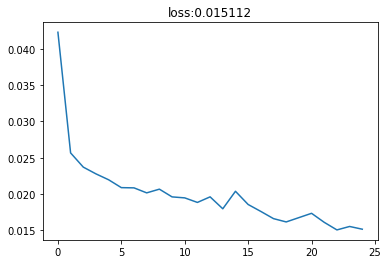

In [43]:
# Plot the losses from the fit
plt.plot(history.history['loss'])

# Use the last loss as the title
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

## Measure performance

0.44523914713050083
-2.6799413359775297


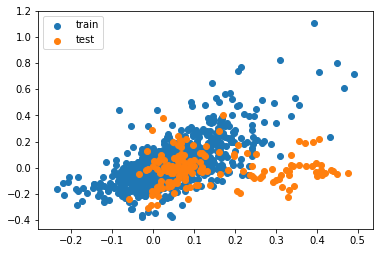

In [44]:
from sklearn.metrics import r2_score

# Calculate R^2 score
train_preds = model_1.predict(scaled_train_features)
test_preds = model_1.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Plot predictions vs actual
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')
plt.legend()
plt.show()